In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pfam's Protein Sequence Classification

Proteins are large biomolecules and macromolecules that comprise one or more long chains of amino acid residues. Proteins are classified based on their amino acid sequence. Proteins perform many functions in within organisms. Proteins are classified based on its amino acid sequence. In this notebook, we use a dataset form the Pfam database to preform a quick analysis and evaluation of how machine learning can be used to autmotically classify protiens from their amino acid sequence.

## Data

In [2]:
# Read CSV files into pandas DataFrames
df_train  = pd.read_csv("../random_split/train.csv", index_col=0)
df_val  = pd.read_csv("../random_split/dev.csv", index_col=0)
df_test  = pd.read_csv("../random_split/test.csv", index_col=0)

data_dict = {"train": df_train, "validation": df_val, "test": df_test}

In [3]:
df_train.family_accession.value_counts()[100]

C:\Users\jamar\AppData\Local\Temp\ipykernel_22728\1682545274.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_train.family_accession.value_counts()[100]


704

## Problem idntified in data exploration

The number of unique family accesion vary significantly from the training to the validation and the test set. Furthermore the data is very imbalance with most classes appearing very few times. Hence ideally to build a machine learning model we can only use the clases that appear a certain minimum of times and that present in all data partitions.

Another problem is the fact that most of the classes appear very few times and hence we don't have enough information train a machine learning model to classify them. Additionally, due to computational reasons we can only have a certain number classes in our model. In this analysis we will stick to using the 100 most common classes.

Furthemore, to have a balanced training set I equaly sample the training set on the 100 most common classes. Since the 100th class appears 704 times in the training set, I randomly sample 704 rows form each class.

<Axes: xlabel='family_accession'>

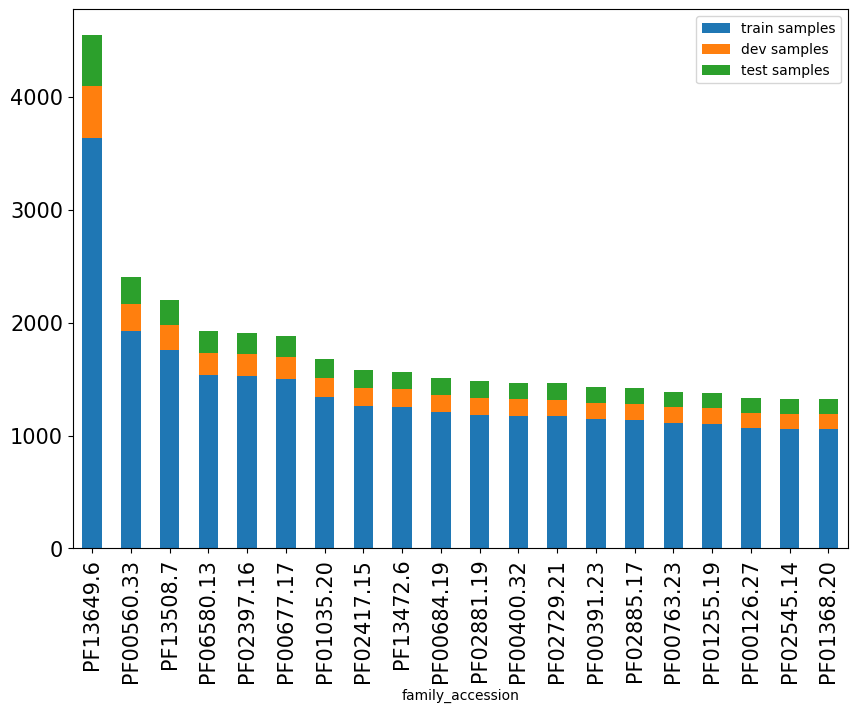

In [4]:
#selecting 250 most common labels
commonLables = df_train.family_accession.value_counts()[:100]

mask = df_train.family_accession.isin(commonLables.index.values)
train_sm = df_train.loc[mask,:]

nrows = len(train_sm)
total_sample_size = 704
train_sm.groupby('family_accession').head()
train_sm = train_sm.groupby('family_accession', group_keys=False).apply(lambda x: x.sample(total_sample_size))
train_sm = train_sm.sample(frac=1).reset_index(drop=True)

mask = df_val.family_accession.isin(commonLables.index.values)
val_sm = df_val.loc[mask,:]

mask = df_test.family_accession.isin(commonLables.index.values)
test_sm = df_test.loc[mask,:]

#inspecting the labels distribution
valCounts = pd.concat([pd.DataFrame(df_train.family_accession.value_counts()[:20]), 
           pd.DataFrame(df_val.family_accession.value_counts()[:20]), 
           pd.DataFrame(df_test.family_accession.value_counts()[:20])], 
          axis=1)
valCounts.columns = ['train samples', 'dev samples', 'test samples']
valCounts.plot.bar(figsize = (10,7), fontsize = 15, stacked=True)

## Creating a unique int for each label

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

< train > Min length: 4, Max length: 2037


c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


< validation > Min length: 9, Max length: 1971


c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


< test > Min length: 9, Max length: 1937


c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


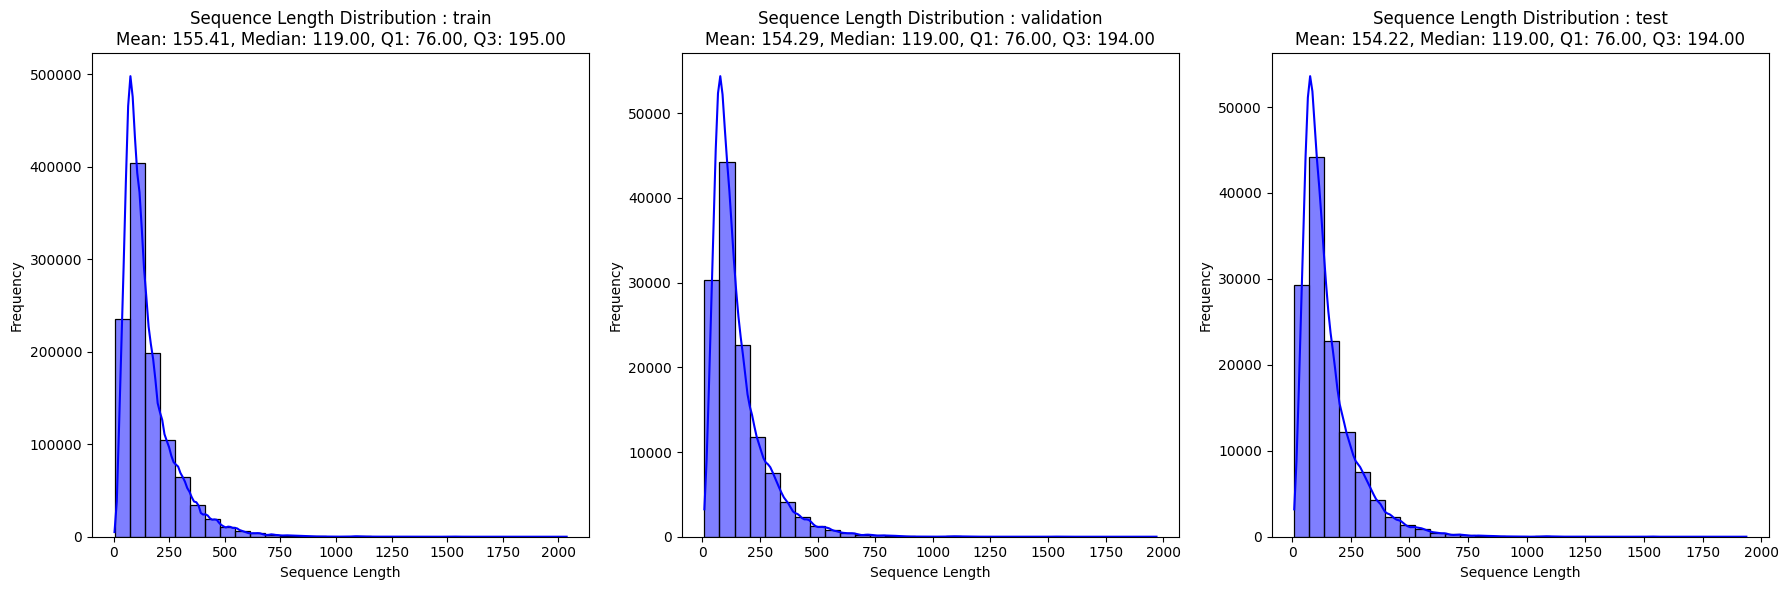

In [6]:
plt.figure(figsize=(18, 6))

for i, dataset in enumerate(data_dict.keys()):
    
    sequence_lengths = data_dict[dataset]['sequence'].apply(len)
    print(f"< {dataset} > Min length: {sequence_lengths.min()}, Max length: {sequence_lengths.max()}")
    
    # Calculate mean and quartiles
    mean_length = np.mean(sequence_lengths)
    median_length = np.median(sequence_lengths)
    q1 = np.percentile(sequence_lengths, 25)
    q3 = np.percentile(sequence_lengths, 75)
    
    # Plot the histogram of sequence lengths
    plt.subplot(1, 3, i+1)
    sns.histplot(sequence_lengths, bins=30, kde=True, color='blue')
    plt.title(f'Sequence Length Distribution : {dataset}\nMean: {mean_length:.2f}, Median: {median_length:.2f}, Q1: {q1:.2f}, Q3: {q3:.2f}')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

Most of the unaligned amino acid sequences have character counts in the range of 50 to 250 with mode around 100. Since we have 100 classes, we need the sequence length to be atleast 100. Hence we will use a sequence length of 200. Sequences less than 200 will be padded and sequences longer than 200 will be truncated.

Codes: Train
Total unique codes: 25
Codes: Val
Total unique codes: 22
Codes: Test
Total unique codes: 24


c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

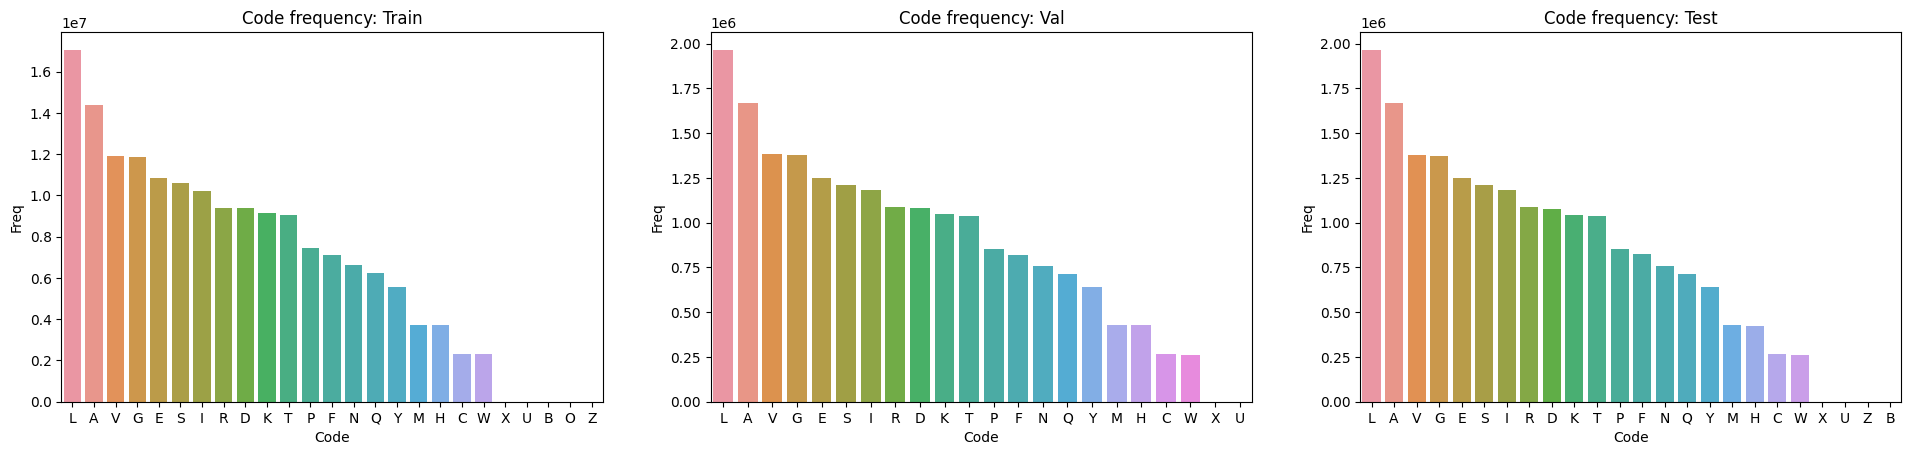

In [7]:
#Inspecting the amino acid codes
from collections import Counter

def get_code_freq(df, data_name):
  
    df = df.apply(lambda x: " ".join(x))
    
    codes = []
    for i in df: # concatination of all codes
        codes.extend(i)
    
    codes_dict= Counter(codes)
    codes_dict.pop(' ') # removing white space
  
    print(f'Codes: {data_name}')
    print(f'Total unique codes: {len(codes_dict.keys())}')

    df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
    return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]
  
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')

# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')

# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')

def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()


## Creating encoding dict for the common amino acids

In [8]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

#encoding the sequences using only the common amino acids dict
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list
  
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm)

In [9]:
#limiting sequence lengths to a 200
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 200
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

print(train_pad.shape, val_pad.shape, test_pad.shape)


(70400, 200) (11545, 200) (11545, 200)


In [10]:
# One hot encoding the sequences
from tensorflow.keras.utils import to_categorical

# Doing the same for the labels
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((70400, 100), (11545, 100), (11545, 100))

## Model

Here we will use a simple bidirectional recurrent neural network to do our classification. This is just an initial baseline model.

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D

x_input = Input(shape=(200))

# embedding layer
emb = Embedding(21, 200, input_length=max_length)(x_input)
# 2 bidirectional LSTMs
bi_rnn1 = Bidirectional(LSTM(200, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4), bias_regularizer=l2(1e-4), activity_regularizer=l2(1e-4)))(emb)
x = Dropout(0.2)(bi_rnn1)

# softmax classifier
x_output = Dense(100, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 200)          4200      
                                                                 
 bidirectional_2 (Bidirecti  (None, 400)               641600    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               40100     
                                                                 
Total params: 685900 (2.62 MB)
Trainable params: 685900 (2.62 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [16]:
# Training the model with an early stop
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history1 = model1.fit(
    train_pad, y_train,
    epochs=20, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )

Epoch 1/20

275/275 [==============================] - 428s 2s/step - loss: 2.3548 - accuracy: 0.4536 - val_loss: 0.6845 - val_accuracy: 0.8709
Epoch 2/20
275/275 [==============================] - 441s 2s/step - loss: 0.4536 - accuracy: 0.9202 - val_loss: 0.2887 - val_accuracy: 0.9652
Epoch 3/20
275/275 [==============================] - 449s 2s/step - loss: 0.2832 - accuracy: 0.9643 - val_loss: 0.2218 - val_accuracy: 0.9777
Epoch 4/20
275/275 [==============================] - 399s 1s/step - loss: 0.2098 - accuracy: 0.9799 - val_loss: 0.1874 - val_accuracy: 0.9833
Epoch 5/20
275/275 [==============================] - 412s 1s/step - loss: 0.1798 - accuracy: 0.9853 - val_loss: 0.1654 - val_accuracy: 0.9868
Epoch 6/20
275/275 [==============================] - 584s 2s/step - loss: 0.1572 - accuracy: 0.9891 - val_loss: 0.1508 - val_accuracy: 0.9884
Epoch 7/20
275/275 [==============================] - 427s 2s/step - loss: 0.1401 - accuracy: 0.9918 - val_loss: 0.1335 - val_accuracy: 0.992

In [17]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

## Showing the model's results

275/275 [==============================] - 87s 315ms/step - loss: 0.0646 - accuracy: 0.9987
Train loss:  0.06455820798873901
Train accuracy:  0.9987074136734009
----------------------------------------------------------------------
46/46 [==============================] - 15s 324ms/step - loss: 0.0776 - accuracy: 0.9951
Val loss:  0.077579565346241
Val accuracy:  0.9950627684593201
----------------------------------------------------------------------
46/46 [==============================] - 15s 326ms/step - loss: 0.0753 - accuracy: 0.9956
Test loss:  0.07531267404556274
Test accuracy:  0.9955825209617615


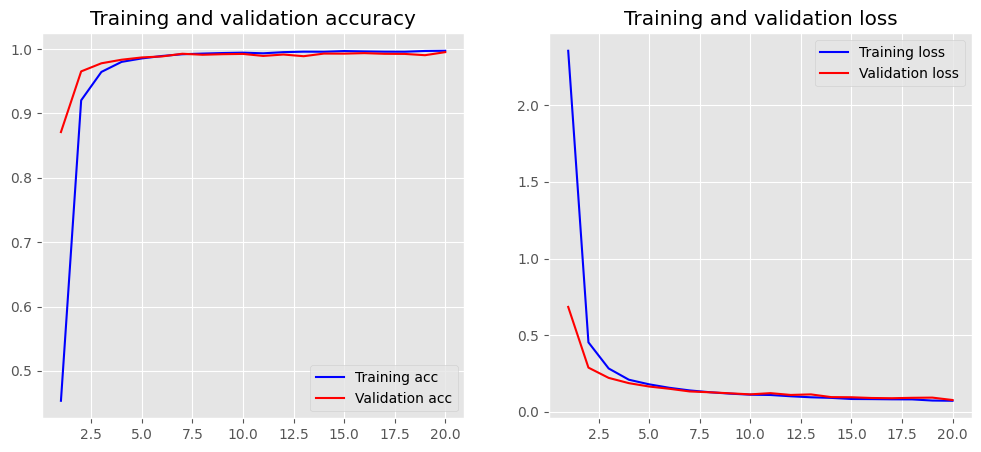

In [18]:
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)

plot_history(history1)

The plots above shows the accuracy and loss on the validation and training set. The accuracy overall is above 95%. The trainining loss and the validation loss follows each other closely thus indicating that we are not having any overfitting. The model performs similarly on the training and the validation set.

361/361 [==============================] - 12s 33ms/step


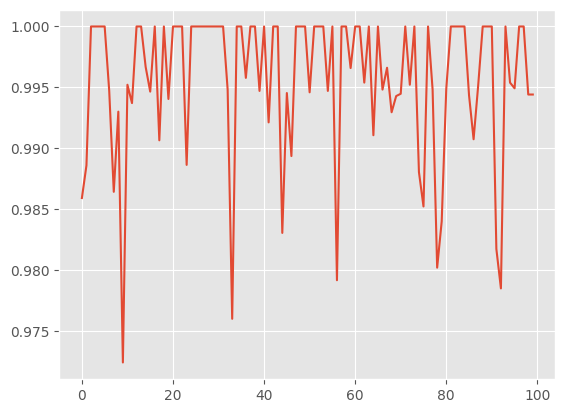

In [20]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model1.predict(test_pad), axis=-1)
y_test2 = np.argmax(y_test, axis=-1)

target_names = [f'class {i}' for i in range(100)]
report = classification_report(y_test2, y_pred, output_dict=True, target_names=target_names)

f1scores = []
for i in range(100):
    f1scores.append(report[f"class {i}"]["f1-score"])

plt.plot(f1scores)
plt.show()

The above plot shows the f-1score for each of our 100 classes evaluated on the test dataset. The results is very promissing with the minimum being around 0.972. In conlusion, it is possible to classify protiens from their amino acid sequence using machine learning provided the problem is properly setup and we have the a good enough balanced dataset for training.